In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import re

from bids import BIDSLayout

from sklearn.model_selection import cross_val_score, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder

from util.decoding.gee import GEEEstimator
from mne_ari import all_resolutions_inference
from mne.decoding import (
    cross_val_multiscore, 
    LinearModel,                  
    SlidingEstimator, 
    get_coef
)
from mne import set_config
set_config('MNE_MEMMAP_MIN_SIZE', '1M')
set_config('MNE_CACHE_DIR', '.tmp')
import mne

In [2]:
# hard-coded values
BIDS_ROOT = 'bids_dataset'
DERIV_ROOT = os.path.join(BIDS_ROOT, 'derivatives')

In [3]:
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subjects = layout.get_subjects(scope = 'preprocessing')
subjects.sort()
task = layout.get_tasks()[0]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/bids/layout/validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [4]:
def load_subj_data(layout, sub):
    
    epochs_fpath = layout.get(
        scope = 'preprocessing', 
        subject = sub, 
        suffix = 'epo', 
        extension = 'fif.gz', 
        return_type = 'filename')[0]
    epochs = mne.read_epochs(epochs_fpath, preload = True, verbose = False)
    X = epochs.get_data() 
    y = epochs.events[:, 2] 
    
    return X, y, epochs


In [5]:
X = []
y = []
sub_ids = []
for sub in subjects:
    sub_num = int(sub)
    _X, _y, epochs = load_subj_data(layout, sub)
    X.append(_X)
    y.append(_y)
    sub_ids.append(np.full_like(_y, sub_num))
X = np.concatenate(X)
y = np.concatenate(y)
sub_ids = np.concatenate(sub_ids)

In [6]:
# define classification pipeline
logistic_reg = GEEEstimator(family = 'binomial', cov_type = 'naive')
clf = LinearModel(logistic_reg)
time_decod = SlidingEstimator(clf, n_jobs = 5, scoring = 'roc_auc', verbose = True)

In [7]:
# perform cross-validation across subjects
cv_methds = [StratifiedGroupKFold(10, shuffle = True, random_state = i) for i in range(10)]
optim_params = dict(maxiter = 100, first_dep_update = 20, params_niter = 10)
scores = [cross_val_multiscore(
    time_decod, 
    X, y, sub_ids,
    fit_params = dict(groups = sub_ids, **optim_params),
    n_jobs = 1,
    cv = cv) for cv in cv_methds
]

  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.2s remaining:    2.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.7s remaining:    2.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.2s remaining:    2.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.1s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.7s remaining:    2.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.6s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.7s remaining:    2.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.5s remaining:    2.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.6s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.7s remaining:    2.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.7s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.7s remaining:    2.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.8s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    2.0s remaining:    1.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.6s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.0s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    2.7s remaining:    1.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.1s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.2s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.3s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.8s remaining:    2.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.6s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.1s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.3s remaining:    2.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.6s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


  0%|          | Fitting SlidingEstimator : 0/84 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.4s finished


In [8]:
def ttest_1samp_corrected(scores, chance = .5):
    '''
    Performs one-sample t-test using the variance correction
    proposed by [1] to correct for the issues caused by 
    overlapping training/test sets across folds (violating 
    independence assumption of a t-test [2]). Recommended 
    cross-validation procedure for good replicability is
    10 times 10-fold cross-validation [3], but the test 
    should be conservative for other r x k-fold schemes.
    
    Input: list of r (k, n_tests) arrays of scores obtained from
            a series of r different k-fold cross validation splits
            
    Output: t-values, p-values, and standard errors from 
            a kx2 t-test for classification metrics with null
            hypothesis that metric == 0.5. These are all
            (n_tests,) arrays. Corrected t-stat derived 
            in [1] and described more readably, with a 
            k-fold formulation given in [3]
            
    References
    ----------
    [1] Nadeau, C., & Bengio, Y. (1999). Inference for the 
        generalization error. Advances in neural information 
        processing systems, 12.
    [2] Dietterich T.G. (1998) Approximate Statistical Tests for 
        Comparing Supervised Classification Learning Algorithms.
        Neural Comput 10:1895–1923
    [3] Bouckaert, R. R., & Frank, E. (2004, May). 
        Evaluating the replicability of significance tests for 
        comparing learning algorithms. In Pacific-Asia conference on 
        knowledge discovery and data mining (pp. 3-12). 
        Springer, Berlin, Heidelberg.
    '''
    from scipy.stats import t as t_dist
    r = len(scores) # number of cross-validation runs
    k = scores[0].shape[0] # number of cross-validation folds
    test_train_ratio = 1/(k - 1)
    scrs = np.concatenate(scores)
    above_chance = scrs - chance
    mean_scr = above_chance.mean(axis = 0)
    var_scr = above_chance.var(axis = 0)
    se_corrected = np.sqrt((1/(k*r) + test_train_ratio) * var_scr)
    t = mean_scr / se_corrected
    p = t_dist.sf(t, df = r*k - 1) # one-sided p-value 
    return t, p, mean_scr + chance, se_corrected

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/mne_ari/ari/parametric.py:62: UserWarning: 
Parametric ARI assumes that the p-values of individual tests are valid when
calculating the true positive proprtion. If this isn't likely true (e.g.
you're using a parametric test on M/EEG data), you may want to consider using
permutation-based ARI instead.

  warnings.warn(


Cluster 1: 214 to 214 ms, observed score = 0.569, p <= 2.6936001188892627e-05
Cluster 2: 229 to 236 ms, observed score = 0.564, p <= 6.078247112904204e-05
Cluster 3: 343 to 343 ms, observed score = 0.553, p <= 0.0004777957624185927


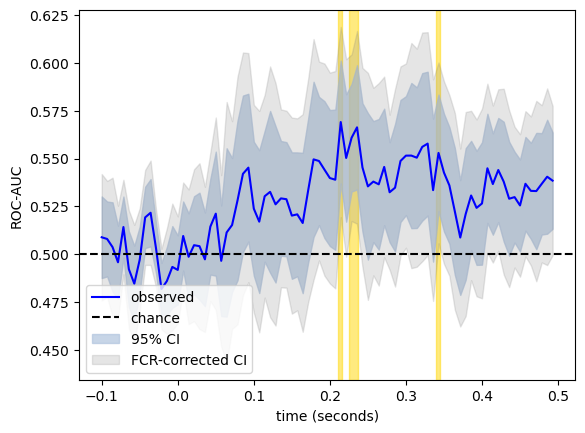

In [9]:
def summarize_results(scores, alpha, metric_name = 'ROC-AUC'):
    
    from mne.stats.cluster_level import _find_clusters
    from scipy.stats import norm
    
    # compare to chance at every time point
    _, p, obs_scores, se = ttest_1samp_corrected(scores)
    # and correct for multiple comparisons 
    _, tdp, clusters = all_resolutions_inference(
        p[np.newaxis, :], alpha, 
        statfun = lambda x: np.squeeze(x), 
        ari_type = 'parametric',
        thresholds = 'all'
        )
    
    # get z-cutoff for post-selection confidence intervals
    # with false-coverage rate correction as
    # described by Rosenblatt & Benjamani (2014)
    n_rejected = np.sum(tdp >= 1 - alpha)
    n_tests = p.size
    alpha_adjusted = alpha * (n_rejected / n_tests)
    z = norm.ppf(1 - alpha/2)
    z_corrected = norm.ppf(1 - alpha_adjusted/2)
    
    # and plot
    fig, ax = plt.subplots()
    ax.plot(epochs.times, obs_scores, color = 'blue', label = 'observed')
    ax.axhline(.5, color = 'black', linestyle = '--', label = 'chance')
    upper = obs_scores + z*se
    lower = obs_scores - z*se
    ax.fill_between(
        epochs.times, 
        upper, lower, 
        color = 'lightsteelblue', 
        alpha = .7, 
        label = '95% CI'
    )
    upper = obs_scores + z_corrected*se
    lower = obs_scores - z_corrected*se
    ax.fill_between(
        epochs.times, 
        upper, lower, 
        color = 'gray', 
        alpha = .2, 
        label = 'FCR-corrected CI'
    )
    ax.set_xlabel('time (seconds)')
    ax.set_ylabel(metric_name)
    ax.legend(loc = 'lower left')
    
    fs = epochs.info['sfreq']
    
    t = []
    
    identity_statfun = lambda x: np.squeeze(x)
    _, _, clusters = all_resolutions_inference(
        p[np.newaxis, :], alpha, 
        statfun = identity_statfun, 
        ari_type = 'parametric'
        )
    
    for i, clust in enumerate(clusters):
        times = epochs.times[clust]
        t_start = min(times)
        t_end = max(times)
        t.append((t_start + t_end)/2)
        ax.axvspan(t_start - .5/fs, t_end + .25/fs, 
                   alpha = .5, color = 'gold', zorder = 0)
        scr = obs_scores[clust].mean() # average within cluster 
        print(
            'Cluster {:d}: {:.0f} to {:.0f} ms, observed score = {:.3f},'.format(
                i + 1, 1e3*t_start, 1e3*t_end, scr
            ) + ' p <= ' + str(p[clust].max())
        )
    return fig, ax, t, clusters

fig, ax, t_indiv, clusts_indiv = summarize_results(scores, alpha = .05)
plt.show()